# Программирование на `C++` и `Python`.
## Дополнительная лекция. Численная оптимизация
Воробьев Виталий, 2020.12.16

Постановка задачи:

$$
\mathrm{argmin}\ f\left(\vec{p}\right)
$$

## Часть 1. Инструменты

### 1.1. Scipy optimize
`optimize.minimize` - численный поиск *локального* минимума скалярной функции нескольких переменных

In [1]:
import numpy as np
from scipy import optimize

$$
f_1(x) = x_0^2 + (x_1 - 0.5)^2 + (x_2 - 1)^2 + \dots
$$

In [2]:
def f1(x):
    return np.sum((x - 0.5*np.arange(x.size))**2)

In [3]:
def f1_deriv(x):
    return 2*x - np.arange(x.size)

In [4]:
res = optimize.minimize(f1, np.zeros(7))
print(res.x)
print(f'f1 calls: {res.nfev}')

[0.         0.50000045 0.99999956 1.50000002 2.00000047 2.49999958
 3.00000003]
f1 calls: 36


In [5]:
res2 = optimize.minimize(f1, np.zeros(7), method='BFGS')
print(res2.x)
print(f'f1 calls: {res2.nfev}')

[0.         0.50000045 0.99999956 1.50000002 2.00000047 2.49999958
 3.00000003]
f1 calls: 36


In [6]:
res3 = optimize.minimize(f1, np.zeros(7), method='BFGS', jac=f1_deriv)
print(res3.x)
print(f'f1 calls: {res3.nfev}')

[0.  0.5 1.  1.5 2.  2.5 3. ]
f1 calls: 4


In [7]:
res4 = optimize.minimize(f1, np.zeros(7), method='Newton-CG', jac=f1_deriv)
print(res4.x)
print(f'f1 calls: {res4.nfev}')

[0.  0.5 1.  1.5 2.  2.5 3. ]
f1 calls: 3


### 1.2. Tensorflow

In [8]:
import tensorflow as tf
import tensorflow.keras as tfk

In [9]:
# optim = tfk.optimizers.Adam()
optim = tfk.optimizers.SGD(learning_rate=0.1)

In [10]:
tfvar = tf.Variable(np.ones(7, dtype=np.float32))

def f1tf():
    return tf.math.reduce_sum((tfvar - 0.5*tf.range(tfvar.shape[0], dtype=float))**2)

In [11]:
for _ in range(100):
    fcalls = optim.minimize(f1tf, [tfvar]).numpy()
print(tfvar.numpy())
print(f'f1 calls: {fcalls}')

[2.0370368e-10 5.0000012e-01 1.0000000e+00 1.4999998e+00 1.9999998e+00
 2.4999995e+00 2.9999995e+00]
f1 calls: 100


### 1.3. iMinuit

In [12]:
from iminuit import Minuit

In [13]:
def fcn(x, y):
    return 1 + 3*x + 6*y - 2*x*y + x**2 + 9*y**2

In [14]:
x, y = np.meshgrid(np.linspace(-10, 5, 100), np.linspace(-5, 5, 100))

In [15]:
import matplotlib.pyplot as plt

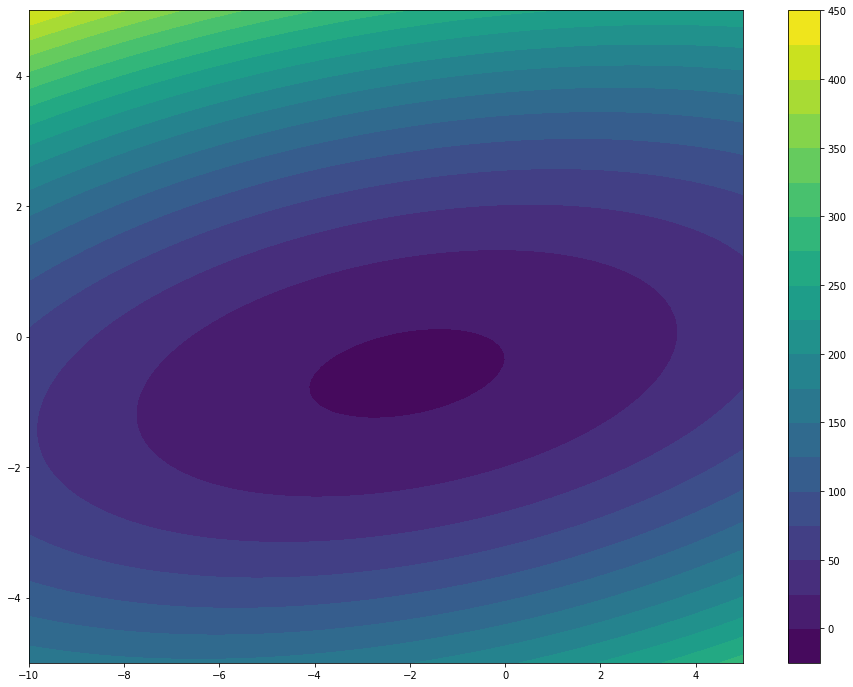

In [16]:
plt.figure(figsize=(16, 12))
c = plt.contourf(x, y, fcn(x,y), levels=20)
plt.colorbar(c);

In [17]:
m = Minuit(fcn, x=0, error_x=0.1, y=0, error_y=0.1, errordef=1)

In [18]:
mres = m.migrad()
mres

------------------------------------------------------------------
| FCN = -3.781                  |      Ncalls=31 (31 total)      |
| EDM = 4.34E-25 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x    |   -2.1    |    1.1    |            |            |         |         |       |
| 1 | y    |   -0.6    |    0.4    |            |            |         |         |       |
------------------------------------------------------------------------------------------

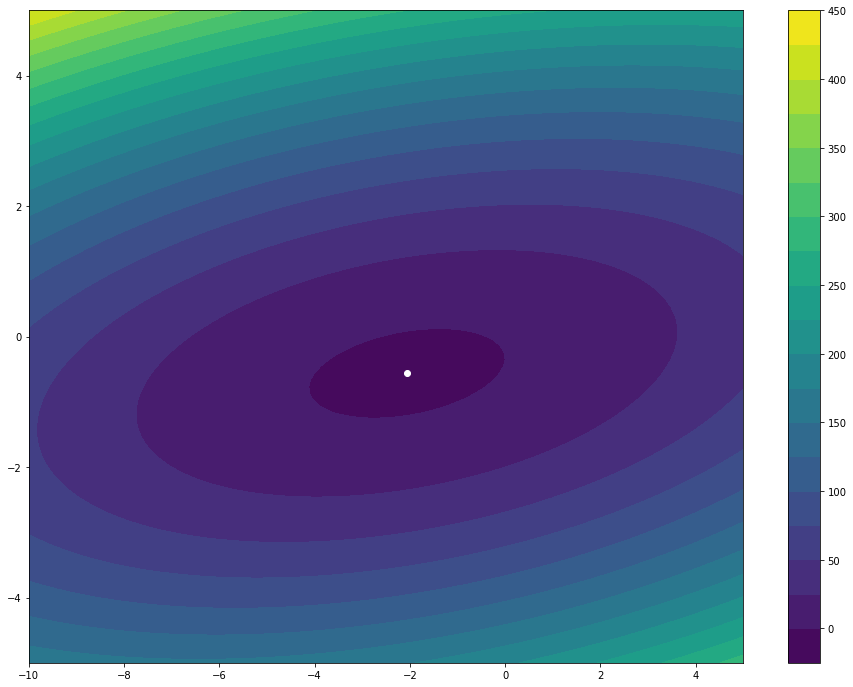

In [19]:
plt.figure(figsize=(16, 12))
c = plt.contourf(x, y, fcn(x,y), levels=20)
plt.colorbar(c);
plt.plot([mres.params[0].value], mres.params[1].value, 'ow');

## Часть 2. Алгоритмы поиска минимума (краткое обсуждение идеи)

В минимуме первая первая производная равна нулю, функция может быть аппроксимирована параболоидом:

$$f(x)\approx f(x_0) + \nabla f(x_0)\cdot(x - x_0) + \frac{1}{2}(x-x_0)^T\mathbf{H}(x_0)(x-x_0)$$

Матрица Гессе (hessian):

$$H_{ij}\equiv \frac{\partial^2 f}{\partial x_i \partial x_j}$$

Идея - делать шаги в направлении антиградиента (градиентный спуск):

$$x_{i+1} = x_i - \lambda\cdot\nabla f(x_i)$$

Как выбрать величину $\lambda$?

* Парабалоид: $\lambda = H^{-1}$
* Метод сопряженных градиентов (`Newton-CG`)
* $\lambda = \mathrm{const}$
* Метод моментов
* RMS prop
* Adam
* ...

In [20]:
def minimize(f, grad, x0, lam=0.1, maxit=100, eps=1e-6):
    fcur = f(x0)
    for _ in range(maxit):
        x0 = x0 - lam * grad(x0)
        fnew = f(x0)
        if np.abs(fcur - fnew) < eps:
            print(f'Converged {np.abs(fcur - fnew)*10**6:.3f}e-6')
            break
        fcur = fnew
    return (fcur, x0)

In [21]:
def f2(x):
    return np.sum((x - np.array([2, 0.3]))**2)

def f2_grad(x):
    return 2 * (x - np.array([2, 0.3]))

In [22]:
fmin, pars = minimize(f2, f2_grad, np.array([0., 1.]), lam=1.e-1, maxit=100)
fmin, pars

Converged 0.649e-6


(1.8037879546808378e-06, array([1.99898588, 0.30035494]))

## Часть 3. Применение алгоритмов оптимизации

### 3.1. Аппроксимация по точкам

In [23]:
x = np.linspace(0, 4, 10)
data = np.sin(x) + 0.05*np.random.default_rng(seed=1).poisson(4, 10)
data

array([ 0.25      ,  0.57995636,  1.02637192,  1.0719379 ,  1.2786557 ,
        0.99522006,  0.70727263,  0.13047682, -0.05224065, -0.5568025 ])

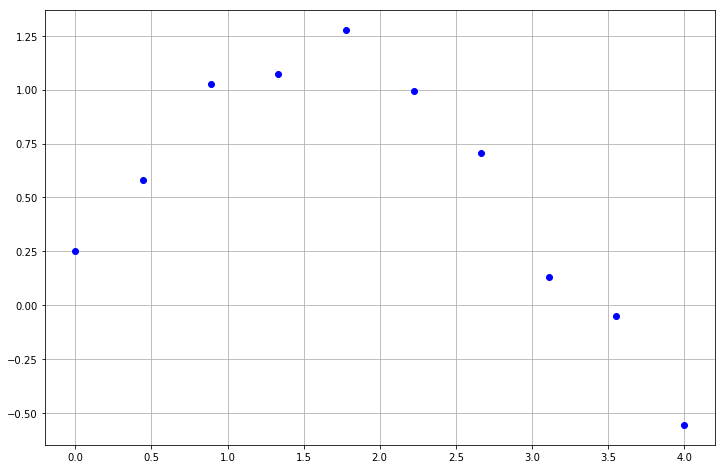

In [24]:
plt.figure(figsize=(12,8))
plt.plot(x, data, 'bo');
plt.grid()

In [25]:
def curve(x, a0, a1, a2, a3):
    return np.polynomial.Polynomial([a0, a1, a2, a3])(x)

res = optimize.curve_fit(curve, x, data)
res

(array([ 0.17427878,  1.44050476, -0.59316933,  0.04652551]),
 array([[ 0.01259369, -0.0218492 ,  0.01028316, -0.0014207 ],
        [-0.0218492 ,  0.06606127, -0.03805445,  0.0058477 ],
        [ 0.01028316, -0.03805445,  0.02386014, -0.00385301],
        [-0.0014207 ,  0.0058477 , -0.00385301,  0.00064217]]))

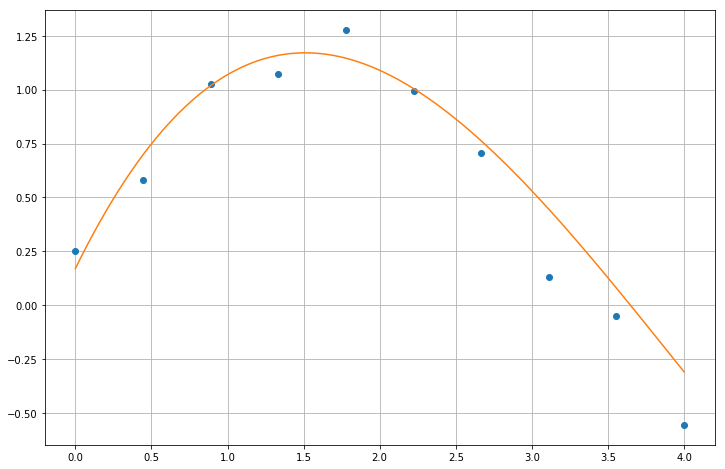

In [26]:
fit = np.polynomial.Polynomial([0.17, 1.44, -0.59, 0.05])
plt.figure(figsize=(12,8))
plt.plot(x, data, 'o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit(x0))
plt.grid()

Root mean squared
$$\mathrm{MSE} = \frac{1}{N}\sum_i \left(y_i - f(x_i)\right)^2\to\mathrm{min}$$

In [27]:
def mse(pars):
    pol = np.polynomial.Polynomial(pars)
    return np.mean((pol(x) - data) ** 2)

def mse_deriv_numeric(pars, eps=1.e-6):
    deriv = []
    for i in range(pars.size):
        pars_posi, pars_nega = pars.copy(), pars.copy()
        pars_posi[i] += eps
        pars_nega[i] -= eps
        deriv.append((mse(pars_posi) - mse(pars_nega)) / (2*eps))
    return np.array(deriv)

def mse_deriv(pars):
    pol = np.polynomial.Polynomial(pars)
    deltay = pol(x) - data
    return 2 * np.array([np.dot(deltay, x**deg) for deg in range(pars.size)]) / deltay.size

In [28]:
pars0 = np.array([0.3, 1.5, -0.7, 0.0])
fmin, pars = minimize(f=mse, grad=mse_deriv, x0=pars0, lam=1.e-6, maxit=5000)
pars

Converged 0.999e-6


array([ 0.3012087 ,  1.50483679, -0.68265536,  0.06265195])

In [29]:
mse(pars0), mse(pars), mse([0.17, 1.44, -0.59, 0.05])

(3.556414796509563, 0.016035796744407416, 0.022572009290284883)

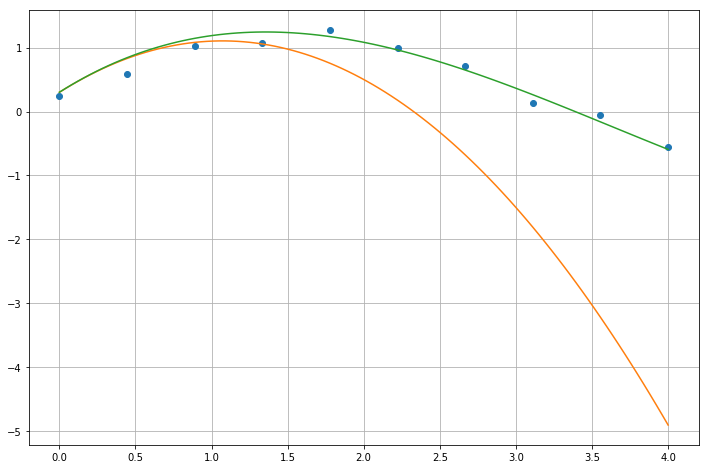

In [30]:
fit0 = np.polynomial.Polynomial(pars0)
fit1 = np.polynomial.Polynomial(pars)
plt.figure(figsize=(12,8))
plt.plot(x, data, 'o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit0(x0))
plt.plot(x0, fit1(x0))
plt.grid()

## Данные с ошибками

In [31]:
sigma = np.ones(data.size)*0.05 + 0.05 * np.random.default_rng(seed=2).uniform(size=data.shape)
sigma[-3] = 1.e-3
sigma

array([0.06308061, 0.06492456, 0.09071129, 0.0545958 , 0.08000503,
       0.08642803, 0.05939505, 0.001     , 0.06374847, 0.08287165])

In [32]:
pars, cov = optimize.curve_fit(curve, x, data, sigma=sigma)
pars

array([ 0.14863253,  1.65517319, -0.79322433,  0.08335995])

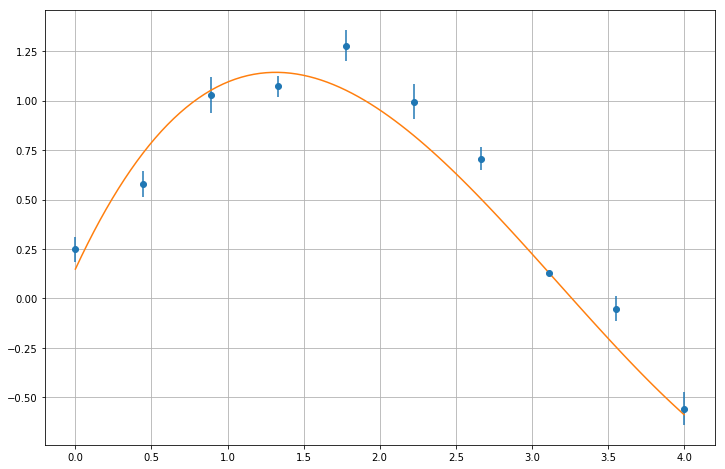

In [33]:
fit = np.polynomial.Polynomial(pars)
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit(x0))
plt.grid()

$$\chi^2 = \sum_i \left(\frac{y_i - f(x_i)}{\sigma_i}\right)^2 \to \mathrm{min}$$

In [34]:
def chisq(pars):
    pol = np.polynomial.Polynomial(pars)
    return np.mean(((pol(x) - data) / sigma) ** 2)

def chisq_deriv(pars):
    pol = np.polynomial.Polynomial(pars)
    deltay = (pol(x) - data) / sigma
    return 2 * np.array([np.dot(deltay, x**deg) for deg in range(pars.size)]) / deltay.size

In [35]:
fmin, pars = minimize(f=chisq, grad=chisq_deriv, x0=pars0, lam=1.e-6, maxit=5000)
pars

array([ 0.29189937,  1.49442209, -0.69712616,  0.06473831])

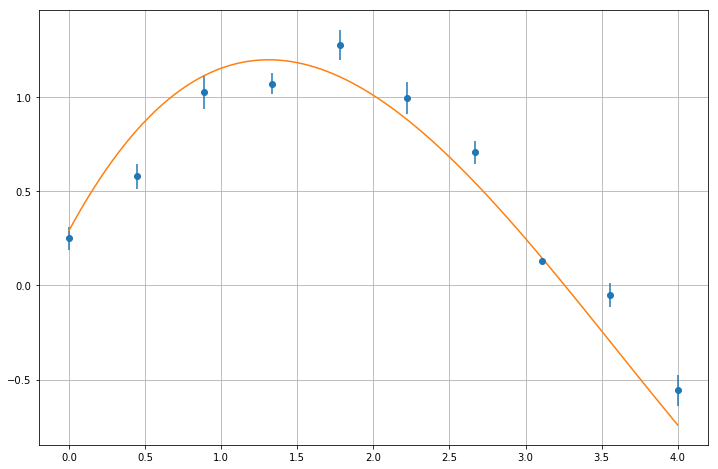

In [36]:
fit = np.polynomial.Polynomial(pars)
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit(x0))
plt.grid()

Какова неопределенность в полученных параметрах?

In [37]:
def f2(phi, a, omega, phi0):
    return a * np.cos(omega * phi + phi0)

def f2_deriv(phi, a, omega, phi0):
    return - omega * a * np.sin(omega * phi + phi0)

In [104]:
x = np.linspace(0, 2*np.pi, 10)
a0, omega0, phi0 = 1.3, 0.6, 0
rng = np.random.default_rng(seed=6)
sigma = 0.02 + 0.08 * rng.uniform(size=x.shape)
data = f2(x, a0, omega0, phi0) + rng.normal(loc=0, scale=sigma, size=x.shape)

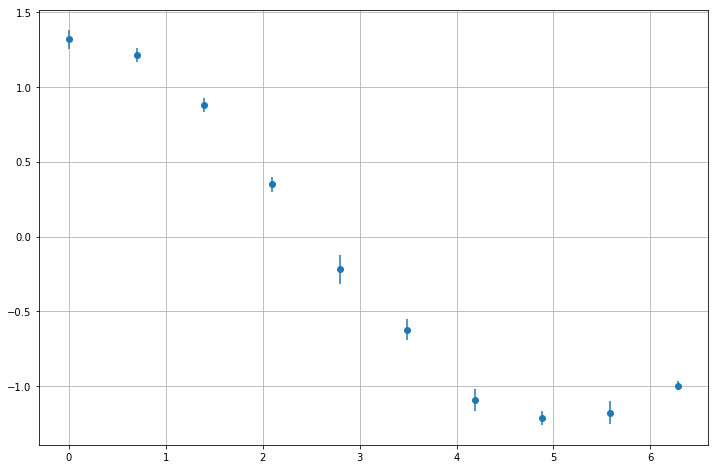

In [105]:
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
plt.grid()

In [106]:
pars, covar = optimize.curve_fit(f2, x, data, sigma=sigma)
pars, covar

(array([-1.28014146,  0.61141285, -3.15836671]),
 array([[ 3.70224076e-04, -1.94565874e-05, -9.32703862e-05],
        [-1.94565874e-05,  7.16795865e-05, -2.46008418e-04],
        [-9.32703862e-05, -2.46008418e-04,  1.20398800e-03]]))

In [107]:
print(f"""
    a = {pars[0]:+.3f} +- {np.sqrt(covar[0,0]):.3f}
omega = {pars[1]:+.3f} +- {np.sqrt(covar[1,1]):.3f}
 phi0 = {pars[2]:+.3f} +- {np.sqrt(covar[2,2]):.3f}
""")


    a = -1.280 +- 0.019
omega = +0.611 +- 0.008
 phi0 = -3.158 +- 0.035



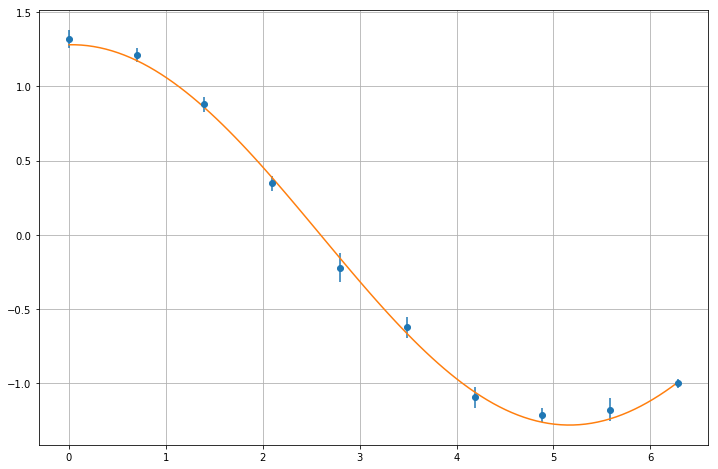

In [108]:
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
x0 = np.linspace(0, 2*np.pi, 100)
plt.plot(x0, f2(x0, *pars))
plt.grid()

In [109]:
def chisq(a, omega, phi0):
    return np.sum(((data - f2(x, a, omega, phi0)) / sigma)**2)

In [110]:
chisq(*pars)

4.771686641613951

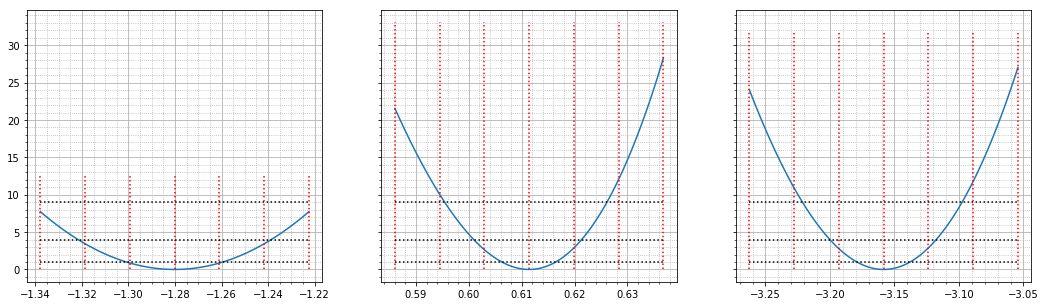

In [111]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
nsgima = 3
for i, a in enumerate(ax):
    a.minorticks_on()
    a.grid(which='major')
    a.grid(which='minor', linestyle=':')
    p0, s0 = pars[i], np.sqrt(covar[i,i])
    parr = np.linspace(p0 - s0*nsgima, p0 + s0*nsgima, 100)
    chiarr = []
    pars_copy = pars.copy()
    for val in parr:
        pars_copy[i] = val
        chiarr.append(chisq(*pars_copy))
    
    a.plot(parr, chiarr - np.min(chiarr));
    
    for j in range(-3, 4):
        a.plot([p0 + j*s0, p0 + j*s0], [0, np.max(chiarr)], 'r:')
    for j in range(1, 4):
        a.plot([parr[0], parr[-1]], [j**2, j**2], 'k:')

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))

for i, a in enumerate(ax):
    p1, s1 = pars[i%3], np.sqrt(covar[i%3,i%3])
    p2, s2 = pars[(i+1)%3], np.sqrt(covar[(i+1)%3,(i+1)%3])
    x, y = np.meshgrid(
        np.linspace(p1 - 3*s1, p1 + 3*s1, 30)
        np.linspace(p2 - 3*s2, p2 + 3*s2, 30)
    )
    parr = 
    chiarr = []
    pars_copy = pars.copy()
    for val in parr:
        pars_copy[i] = val
        chiarr.append(chisq(*pars_copy))
    
    a.plot(parr, chiarr - np.min(chiarr));
    
    for j in range(-3, 4):
        a.plot([p0 + j*s0, p0 + j*s0], [0, np.max(chiarr)], 'r:')